<a href="https://colab.research.google.com/github/Tlen33/Reinforcement-learning/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка модулей

!pip install gym==0.18.3
!pip install atari-py==0.2.5

     |████████████████████████████████| 1.6 MB 6.8 MB/s 
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657526 sha256=f81743c73a39014e9bbc4ef2bc1d0021b380f79b14b34cd4b0949ed057330e43
  Stored in directory: /root/.cache/pip/wheels/1a/ec/6d/705d53925f481ab70fd48ec7728558745eeae14dfda3b49c99
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8 MB 7.5 MB/s 
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [ ]:
# Загружаем библиотеку

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, Conv1D, MaxPooling2D, Reshape, Multiply
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import tensorflow.keras as keras 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import gym

%matplotlib inline

In [ ]:
# Подключаем диск

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Отключаем функционал из tf2.0

tf.compat.v1.disable_eager_execution()

In [ ]:
# Создаем среду игры

env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

(210, 160, 3)

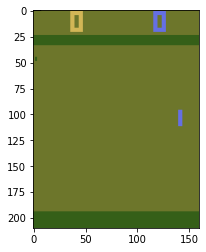

In [ ]:
# Вызовем визуализацию состояния среды

plt.imshow(observation)
plt.show() 

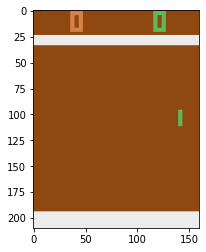

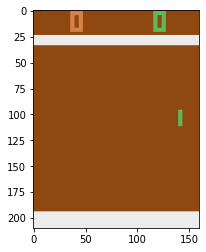

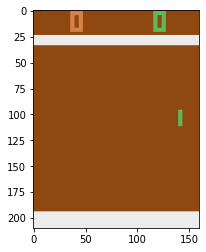

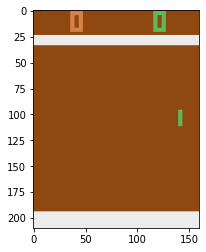

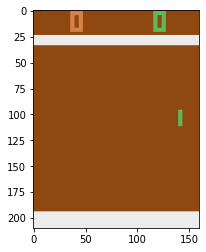

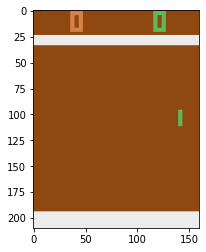

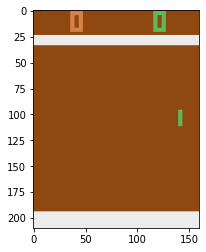

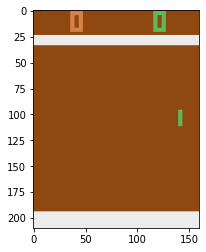

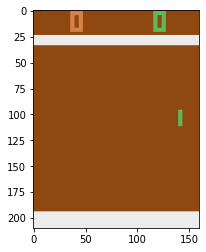

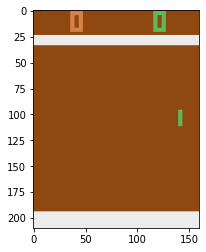

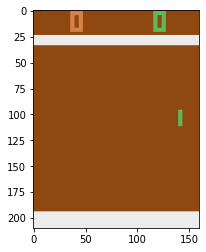

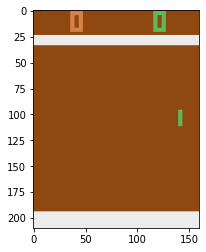

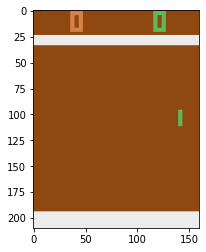

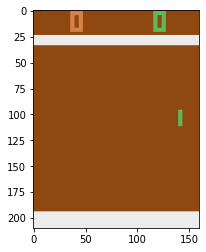

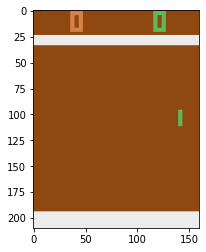

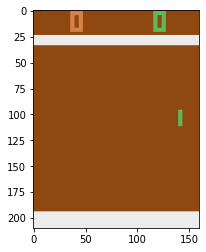

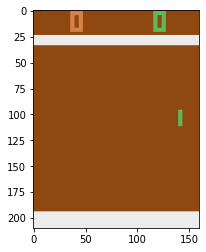

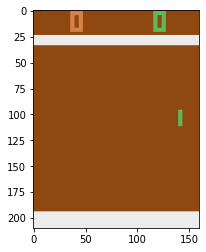

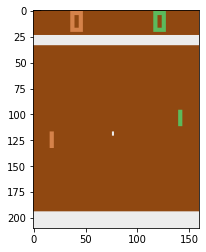

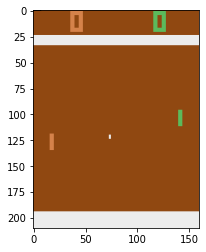

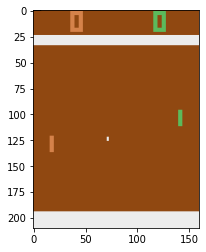

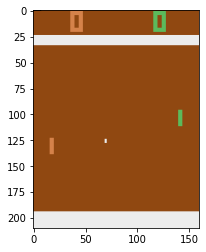

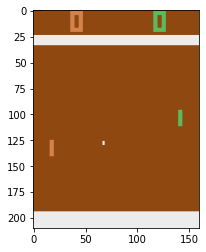

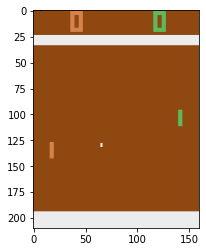

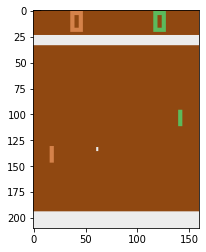

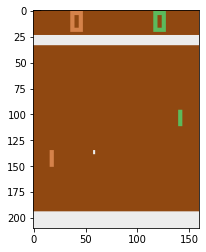

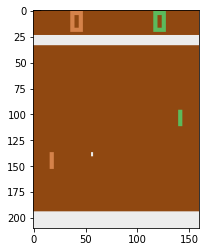

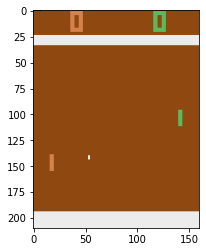

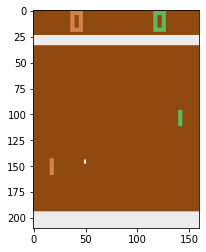

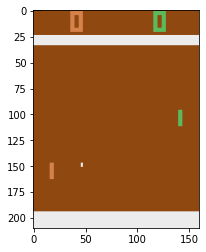

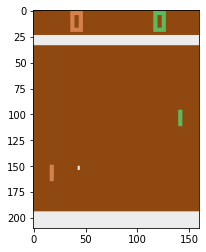

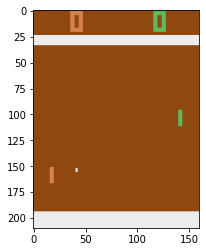

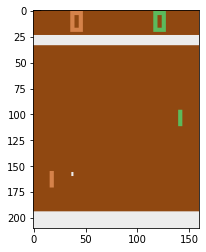

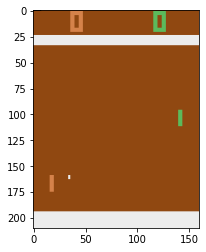

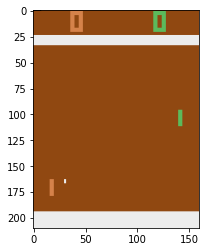

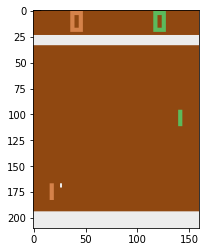

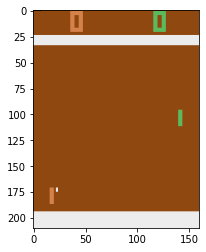

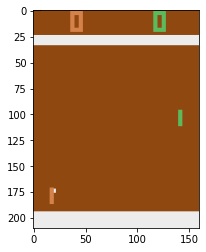

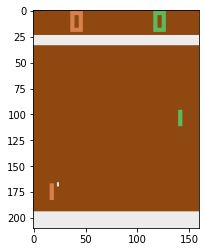

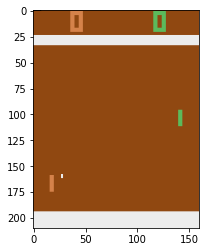

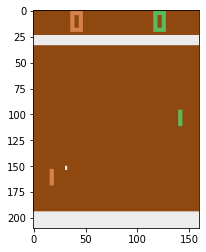

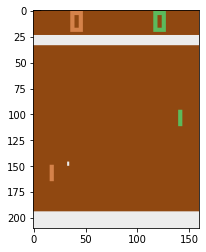

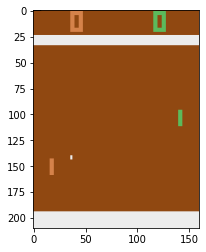

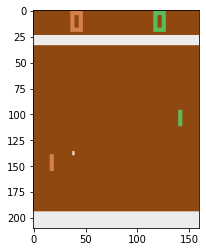

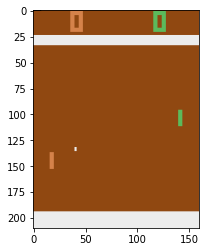

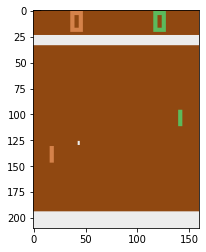

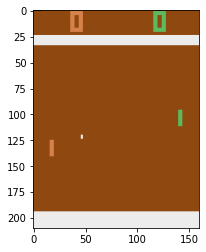

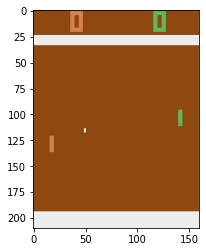

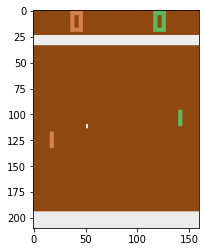

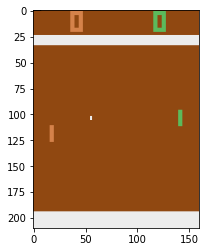

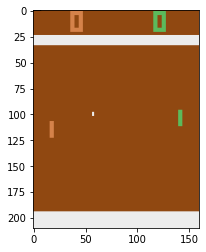

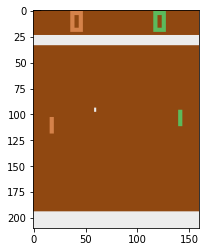

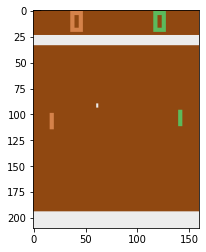

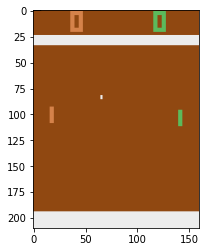

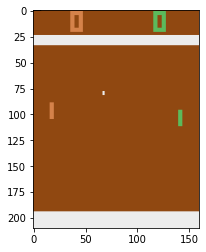

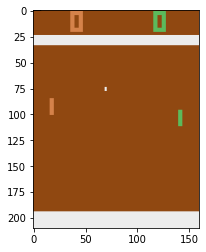

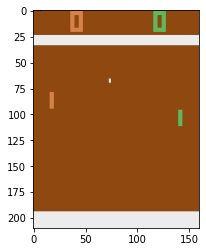

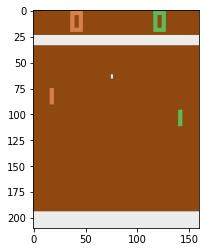

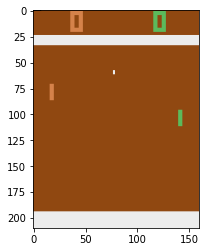

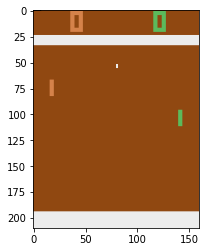

In [ ]:
# Проиграем вперёд игру на 30 кадров чтобы увидеть полную сцену игры

for i in range(60):
    observation, reward, done, info = env.step(0)
    plt.imshow(observation)
    plt.show()

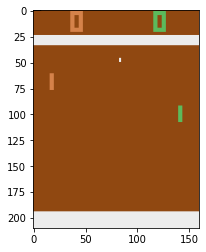

In [ ]:
newObservation, reward, done, info = env.step(2)
plt.imshow(newObservation)

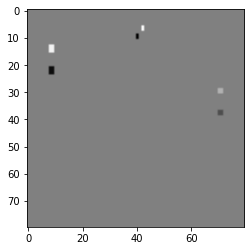

In [ ]:
# Функцию предобработки данных для подачи в нейросеть

def preprocessFrames(newFrame, lastFrame):
  nFrame = newFrame.astype(np.int32)
  nFrame[nFrame==144] = 0
  nFrame[nFrame==72] = 0
  lFrame = lastFrame.astype(np.int32)
  lFrame[lFrame==144] = 0
  lFrame[lFrame==72] = 0
  deltaFrame = nFrame - lFrame
  deltaFrame = deltaFrame[35:195]
  deltaFrame=deltaFrame[::2,::2, 0]
  maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
  if maxValue != 0:
      deltaFrame=deltaFrame/maxValue
  return deltaFrame

plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray)

In [ ]:
# Массив состояния среды

preprocessFrames(newObservation, observation)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Форма массива

preprocessFrames(newObservation, observation).shape

(80, 80)

In [ ]:
# Простая нейронка

inputs = Input(shape=(80,80))
flattenedLayer = Flatten()(inputs)
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 200)               1280000   
                                                                 
 dense_1 (Dense)             (None, 1)                 200       
                                                                 
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Задаем награду за эпизод

episodeReward = Input(shape=(1,), name='episodeReward')

In [ ]:
# Функция потерь

def rewardedLoss(episodeReward):
  def loss(yTrue,yPred):
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    policyLoss = Multiply()([tmpLoss, episodeReward])
    return policyLoss
  return loss

In [ ]:
# Создаем керас-оптимизатор и нейронку для обучения

episodeReward = Input(shape=(1,), name='episodeReward')
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)
 
myOptimizer = RMSprop(lr=0.0001)
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Функция для генерации игрового эпизода с участием нейросети

def generateEpisode(policyNetwork):
  statesList = []
  upDownActionList=[]
  rewardsList=[]
  networkOutputList=[]
  env=gym.make("Pong-v0")
  observation = env.reset()
  newObservation = observation
  done = False
 
  while done == False:
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation)
    statesList.append(processedNetworkInput)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0)
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0]
    
    networkOutputList.append(upProbability)
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
 
    if actualAction == 2:
      upDownActionList.append(1.0)
    else:
      upDownActionList.append(0.0)
 
    observation = newObservation
    newObservation, reward, done, info = env.step(actualAction)
    rewardsList.append(reward)
 
    if done:
      break
 
  env.close()
  return statesList, upDownActionList, rewardsList, networkOutputList

In [ ]:
# Генерируем эпизод игры с необученной сетью

statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList)))
print("Форма состояния "+str(statesList[0].shape))
print("Количество наград за эпизод = "+str(len(rewardsList)))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


----------------------
Количество состояний в эпизоде = 1935
Форма состояния (80, 80)
Количество наград за эпизод = 1935


In [ ]:
# Сколько мы раз выиграли в течение эпизода

print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList)))))
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList)))))
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList)))))

Количество выигранных очков = 2
Количество проигранных очков = 21
Количество нулевых наград = 1912


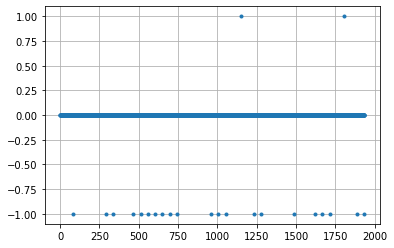

In [ ]:
# Выведем на графике полученные награды

plt.plot(rewardsList, '.')
ax=plt.gca()
ax.grid(True)

In [ ]:
# Функция для распределения ненулевой награды

def processRewards(rewardList):
  rewardDecay = 0.99
  tmpReward = 0
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32)
  for i in range(len(rewardList)-1, -1, -1):
    if rewardList[i] == 0:
      tmpReward = tmpReward*rewardDecay
      rewardDecayed[i] = tmpReward
    else:
      tmpReward = rewardList[i]
      rewardDecayed[i] = tmpReward

  rewardDecayed -= np.mean(rewardDecayed)
  rewardDecayed /= np.std(rewardDecayed)
  return rewardDecayed

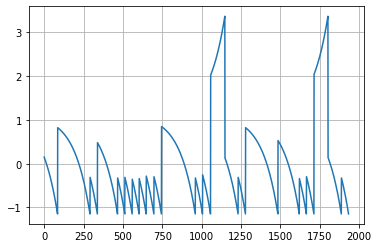

In [ ]:
# Распределение наград по новой функции

plt.plot(processRewards(rewardsList),'-')
ax = plt.gca()
ax.grid(True)

In [ ]:
# Сгенерируем новый игровой эпизод

statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
print("Количество состояний среды = "+str(len(statesList)))
print("Форма состояний среды = "+str(statesList[0].shape))
print("Список наград  = "+str(len(rewardsList)))

Количество состояний среды = 1105
Форма состояний среды = (80, 80)
Список наград  = 1105


In [ ]:
# Данные для тренировки

x = np.array(statesList)
episodeReward = np.expand_dims(processRewards(rewardsList), 1)
yTmp = np.array(upDownActionList)
yTrue = np.expand_dims(yTmp, 1)
print("Форма наград за эпизод =", episodeReward.shape)
print("Форма состояний среды =", x.shape)
print("Форма фактических движений =", yTrue.shape)

Форма наград за эпизод = (1105, 1)
Форма состояний среды = (1105, 80, 80)
Форма фактических движений = (1105, 1)


In [ ]:
episodeReward[:20]

array([[2.1773274],
       [2.147766 ],
       [2.117906 ],
       [2.0877445],
       [2.0572782],
       [2.0265043],
       [1.9954195],
       [1.9640208],
       [1.9323049],
       [1.9002684],
       [1.8679086],
       [1.8352218],
       [1.8022048],
       [1.7688543],
       [1.7351669],
       [1.7011395],
       [1.666768 ],
       [1.6320497],
       [1.5969803],
       [1.5615569]], dtype=float32)

In [ ]:
# Загружаем в модель новые 'x' и 'y'

policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Train on 1105 samples
1105/1105 [==============================] - 0s 211us/sample - loss: -0.0013


In [ ]:
# Создаём серию игровых эпизодов и загружаем в нейронку

def generateEpisodeBatchesTraining(model, nBatches=10):
  env = gym.make('Pong-v0')
  batchStateList = []
  batchUpDownActionList = []
  batchRewardsList = []
  batchNetworkOutputList = []
  for i in range(nBatches):
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model)
    batchStateList.extend(statesList)
    batchNetworkOutputList.extend(networkOutputList)
    batchUpDownActionList.extend(upDownActionList)
    batchRewardsList.extend(rewardsList)
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1)
  x = np.array(batchStateList)
  yTmp = np.array(batchUpDownActionList)
  yTrue = np.expand_dims(yTmp, 1)
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0)
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss

In [ ]:
# Тренируем нейронку - 10 тренировок

trainingTimes = 10
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 106сек
Ошибка на тренировке = -0.09032
Выиграли очков = 55 Проиграли очков = 210

Тренировка = 2
Время тренировки = 83сек
Ошибка на тренировке = -0.10013
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 3
Время тренировки = 104сек
Ошибка на тренировке = -0.08598
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 4
Время тренировки = 98сек
Ошибка на тренировке = -0.08934
Выиграли очков = 49 Проиграли очков = 210

Тренировка = 5
Время тренировки = 87сек
Ошибка на тренировке = -0.07106
Выиграли очков = 30 Проиграли очков = 210

Тренировка = 6
Время тренировки = 126сек
Ошибка на тренировке = -0.08429
Выиграли очков = 68 Проиграли очков = 210

Тренировка = 7
Время тренировки = 123сек
Ошибка на тренировке = -0.07099
Выиграли очков = 58 Проиграли очков = 210

Тренировка = 8
Время тренировки = 94сек
Ошибка на тренировке = -0.0811
Выиграли очков = 34 Проиграли очков = 210

Тренировка = 9
Время тренировки = 101сек
Ошибка на тренировке = -0.09925
Выиг

In [ ]:
# Тренируем нейронку - 20 тренировок

trainingTimes = 20
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 115сек
Ошибка на тренировке = -0.09098
Выиграли очков = 71 Проиграли очков = 210

Тренировка = 2
Время тренировки = 112сек
Ошибка на тренировке = -0.09331
Выиграли очков = 52 Проиграли очков = 210

Тренировка = 3
Время тренировки = 106сек
Ошибка на тренировке = -0.07063
Выиграли очков = 65 Проиграли очков = 210

Тренировка = 4
Время тренировки = 96сек
Ошибка на тренировке = -0.06282
Выиграли очков = 52 Проиграли очков = 210

Тренировка = 5
Время тренировки = 84сек
Ошибка на тренировке = -0.08929
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 6
Время тренировки = 96сек
Ошибка на тренировке = -0.06683
Выиграли очков = 46 Проиграли очков = 210

Тренировка = 7
Время тренировки = 110сек
Ошибка на тренировке = -0.07599
Выиграли очков = 41 Проиграли очков = 210

Тренировка = 8
Время тренировки = 110сек
Ошибка на тренировке = -0.09161
Выиграли очков = 52 Проиграли очков = 210

Тренировка = 9
Время тренировки = 104сек
Ошибка на тренировке = -0.09277
Вы

In [ ]:
# Тренируем нейронку - 30 тренировок

trainingTimes = 30
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 129сек
Ошибка на тренировке = -0.09388
Выиграли очков = 84 Проиграли очков = 210

Тренировка = 2
Время тренировки = 96сек
Ошибка на тренировке = -0.10317
Выиграли очков = 64 Проиграли очков = 210

Тренировка = 3
Время тренировки = 92сек
Ошибка на тренировке = -0.11153
Выиграли очков = 42 Проиграли очков = 210

Тренировка = 4
Время тренировки = 111сек
Ошибка на тренировке = -0.10993
Выиграли очков = 78 Проиграли очков = 210

Тренировка = 5
Время тренировки = 102сек
Ошибка на тренировке = -0.10644
Выиграли очков = 47 Проиграли очков = 210

Тренировка = 6
Время тренировки = 94сек
Ошибка на тренировке = -0.09336
Выиграли очков = 36 Проиграли очков = 210

Тренировка = 7
Время тренировки = 107сек
Ошибка на тренировке = -0.10838
Выиграли очков = 53 Проиграли очков = 210

Тренировка = 8
Время тренировки = 99сек
Ошибка на тренировке = -0.13686
Выиграли очков = 67 Проиграли очков = 210

Тренировка = 9
Время тренировки = 97сек
Ошибка на тренировке = -0.14172
Выиг

In [ ]:
# Нейронка 2.1 - изменим количество связей в Dense слое. Увеличил до 333.

inputs = Input(shape=(80,80))
flattenedLayer = Flatten()(inputs)
fullConnected = Dense(333, activation='relu', use_bias=False)(flattenedLayer)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 333)               2131200   
                                                                 
 dense_3 (Dense)             (None, 1)                 333       
                                                                 
Total params: 2,131,533
Trainable params: 2,131,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Тренируем нейронку 2.1 - 15 тренировок

trainingTimes = 15
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Тренировка = 1
Время тренировки = 48сек
Ошибка на тренировке = -0.0486
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 2
Время тренировки = 53сек
Ошибка на тренировке = -0.0522
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 3
Время тренировки = 44сек
Ошибка на тренировке = -0.0877
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 4
Время тренировки = 47сек
Ошибка на тренировке = -0.07345
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 5
Время тренировки = 46сек
Ошибка на тренировке = -0.04363
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 6
Время тренировки = 45сек
Ошибка на тренировке = -0.09661
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 7
Время тренировки = 45сек
Ошибка на тренировке = -0.05095
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 8
Время тренировки = 46сек
Ошибка на тренировке = -0.08673
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 9
Время тренировки = 48сек
Ошибка на тренировке = -0.05732
Выиграли очков = 7

In [ ]:
# Нейронка 2.2 - изменим количество связей в Dense слое. Увеличил до 333. Добавил Dense слой.

inputs = Input(shape=(80,80))
fullConnected = Flatten()(inputs)
fullConnected = Dense(333, activation='relu', use_bias=False)(fullConnected)
fullConnected = Dense(555, activation='relu', use_bias=False)(fullConnected)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_5 (Dense)             (None, 333)               2131200   
                                                                 
 dense_6 (Dense)             (None, 555)               184815    
                                                                 
 dense_7 (Dense)             (None, 1)                 555       
                                                                 
Total params: 2,316,570
Trainable params: 2,316,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Тренируем нейронку 2.2 - 15 тренировок

trainingTimes = 15
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Тренировка = 1
Время тренировки = 47сек
Ошибка на тренировке = -0.02945
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 2
Время тренировки = 46сек
Ошибка на тренировке = -0.05955
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 3
Время тренировки = 45сек
Ошибка на тренировке = -0.09073
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 4
Время тренировки = 46сек
Ошибка на тренировке = -0.11619
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 5
Время тренировки = 48сек
Ошибка на тренировке = -0.1052
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 6
Время тренировки = 44сек
Ошибка на тренировке = -0.12382
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 7
Время тренировки = 43сек
Ошибка на тренировке = -0.08912
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 8
Время тренировки = 50сек
Ошибка на тренировке = -0.08712
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 9
Время тренировки = 46сек
Ошибка на тренировке = -0.09175
Выиграли очков = 

In [ ]:
# Нейронка 2.3 - изменим количество связей в Dense слое. Увеличил до 333. Добавил Dense слой. Добавил Conv слой.

inputs = Input(shape=(80,80))
fullConnected = Conv1D(2, 2, padding='same', activation='relu', use_bias=False)(inputs)
fullConnected = Flatten()(fullConnected)
fullConnected = Dense(333, activation='relu', use_bias=False)(fullConnected)
fullConnected = Dense(555, activation='relu', use_bias=False)(fullConnected)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 80, 80)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 2)             320       
                                                                 
 flatten_22 (Flatten)        (None, 160)               0         
                                                                 
 dense_44 (Dense)            (None, 333)               53280     
                                                                 
 dense_45 (Dense)            (None, 555)               184815    
                                                                 
 dense_46 (Dense)            (None, 1)                 555       
                                                                 
Total params: 238,970
Trainable params: 238,970
Non-traina

In [ ]:
# Тренируем нейронку 2.3 - 15 тренировок

trainingTimes = 15
for training in range(trainingTimes):
  startTime = time.time()
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print("Тренировка = " + str((training)+1))
  print("Время тренировки = " + str(round(endTime - startTime))+"сек")
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))
  rr=np.array(rewardsList)
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0])))
  print("")
  if training % 10 == 0:
    policyNetworkModel.save("policyNetworkModel.h5")
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")
    with open('rewardsModelSimple.txt','a') as recordingRewards:
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Тренировка = 1
Время тренировки = 54сек
Ошибка на тренировке = -0.07199
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 2
Время тренировки = 52сек
Ошибка на тренировке = -0.0621
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 3
Время тренировки = 50сек
Ошибка на тренировке = -0.0722
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 4
Время тренировки = 51сек
Ошибка на тренировке = -0.06846
Выиграли очков = 8 Проиграли очков = 210

Тренировка = 5
Время тренировки = 49сек
Ошибка на тренировке = -0.08261
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 6
Время тренировки = 54сек
Ошибка на тренировке = -0.05811
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 7
Время тренировки = 53сек
Ошибка на тренировке = -0.06964
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 8
Время тренировки = 54сек
Ошибка на тренировке = -0.05741
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 9
Время тренировки = 50сек
Ошибка на тренировке = -0.08477
Выиграли очков = 

In [ ]:
# Результаты по последней тренировке

1.1 10 тренировок - выиграли очков = 58
1.2 20 тренировок - выиграли очков = 58
1.3 30 тренировок - выиграли очков = 63
2.1 15 тренировок - выиграли очков = 4
2.2 15 тренировок - выиграли очков = 6
2.3 15 тренировок - выиграли очков = 4